In [7]:
# install dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

In [8]:
!pip install -q tf-models-official

In [9]:
import os
import shutil
import re
import json
import gc

import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import nltk

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [10]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Preprocessing

In [11]:
data_file_name_dict = {
    '2014':'bostonglobe2014.csv',
    '2015':'bostonglobe2016.csv',
    '2016':'bostonglobe2015.csv',
    '2017':'bostonglobe2017.csv',
    # '2018':'bostonglobe2018.csv',
}
TARGET_WORDS = ['black', 'cape verdean', 'afro latino', 'haitian', 'african american', 'african-american', 'caribbean', 'jmaican', 'dominican', 'west indian']

In [12]:
def tokenize(text):
    tokens = []
    for token in nltk.word_tokenize(text):
      if (token.isalnum()):
        tokens.append(token)
    return " ".join(tokens)

In [13]:
def clean_text(text):
    # text = re.sub(r"[\[\]]", "", text)
    text = re.sub(r"['\['\]]", "", text)
    text = re.sub(r"\n", "", text.lower())
    # text = tokenize(text)
    return text

In [14]:
def extract_sentences(text):
    """
        extract sentences from text file
    """
    # tokenized_words = tokenize(text)
    sentences = nltk.sent_tokenize(text)
    sentences = [tokenize(sentence) for sentence in sentences]
    return  sentences

In [15]:
def process_files(file_names):
  data_frames = {}
  for key, val in file_names.items():
    df = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/data/boston-globe/{val}')
    df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
    df['text'] = df['text'].apply(clean_text)
    # df['sentences'] = df['text'].apply(extract_sentences)
    data_frames[f"{key}"] = df
  return data_frames

In [16]:
processed_dfs = process_files(data_file_name_dict)

# Pre training dataset

Download and extract the dataset.

In [ ]:
# Download dataset
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

In [ ]:
# extract dataset
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.25,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.25,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['they’re having a really hard time dealing with what they saw and experienced that day']
text_preprocessed = bert_preprocess_model(text_test)
print(text_preprocessed)

## Setup BERT model

In [17]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.7409344  -0.28116405 -0.31312478  0.47934732  0.24215393 -0.27223784
  0.24488892  0.11676791 -0.18976676 -0.9989294   0.0038644   0.70991   ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.67495686  0.39631575 -0.17868163 ... -0.301179    0.52392757
   0.16845411]
 [ 0.5983113   0.48880827 -0.30609077 ... -0.52545214  1.0947837
  -0.1719397 ]
 [ 0.7551388  -0.10262445  1.0689487  ... -0.57726055 -0.10445885
  -0.6713221 ]
 ...
 [ 0.14580089  1.0499463  -0.11399288 ... -0.59016424 -0.40768573
  -0.5178602 ]
 [-0.5375041   0.68704563  0.07562196 ... -0.29087263 -0.2488248
  -0.31457156]
 [ 0.15623756  0.35464486 -0.9811838  ... -0.15551999  0.0944948
  -0.3902223 ]]


## Define model


In [18]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

check that the model runs with the output of the preprocessing model.

In [19]:
model = build_classifier_model()
bert_raw_result = model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.71919984]], shape=(1, 1), dtype=float32)


In [23]:
# tf.keras.utils.plot_model(model)

### Loss function

In [24]:
# setup binary crossentropy loss
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer
use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). 

In [25]:
epochs = 8
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

In [95]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [97]:
print(f'Training model with {tfhub_handle_encoder}')
history = model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

### Evaluate the model

In [93]:
loss, accuracy = model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

### Plot the accuracy and loss over time

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [17]:
model_fname = 'IMDB_BERT_CLASSIFIER_3'
my_wd = '/content/drive/MyDrive/Colab Notebooks/Models/'
saved_model_path = os.path.join(my_wd, model_fname)

In [21]:
model.save(saved_model_path, include_optimizer=False)

#### load saved model

In [18]:
model = tf.saved_model.load(saved_model_path)

In [23]:
def process_articles(articles):
  print(len(articles))
  selected_sentences = []
  for article in articles:
    result = [word for word in TARGET_WORDS if(word in article)]
    if (bool(result)):
      selected_sentences.append(article)
  print(len(selected_sentences))
  return selected_sentences

In [24]:
def write_to_file(document, file):
    document = json.dumps(document)
    with open(file, 'w') as f:
        f.write(document)
    print("file write to disk complete")

In [17]:
# def predict_sentiments(data_frames):
#   total_sentiment_frequency = {}

#   for key, df in data_frames.items():
#     pred_sentences = process_articles(df['text'])
    
#     parsed_results = tf.sigmoid(model(tf.constant(pred_sentences))).numpy()
#     sentiment_frequency = { 
#       "Negative": 0,
#       "Positive": 0,
#     }
#     for i in parsed_results:
#       if (i[0] > 0.5):
#         sentiment_frequency['Positive'] += 1
#       else:
#         sentiment_frequency['Negative'] += 1
#     total_sentiment_frequency[key] = sentiment_frequency
#     file = f'/content/drive/MyDrive/Colab Notebooks/results/total_sentiment_frequency'
#     write_to_file(total_sentiment_frequency, file)
#   return total_sentiment_frequency

In [25]:
def predict_sentiments(key, dataframe):
  print(key)
  pred_sentences = process_articles(dataframe['text'])
  
  parsed_results = tf.sigmoid(model(tf.constant(pred_sentences))).numpy()
  sentiment_frequency = { 
    "Negative": 0,
    "Positive": 0,
  }
  for i in parsed_results:
    if (i[0] > 0.5):
      sentiment_frequency['Positive'] += 1
    else:
      sentiment_frequency['Negative'] += 1
  file = f'/content/drive/MyDrive/Colab Notebooks/results/sentiment_frequency_{key}'
  write_to_file(sentiment_frequency, file)
  return sentiment_frequency

In [ ]:
# change the key value to values between 2014-2018 to generate sentiment predictions for all articles in the said year
key = '2018'
sentiment_frequency = predict_sentiments(key, processed_dfs[key])

2018
8291
3260


In [ ]:
# total_sentiment_frequency = {}
# for key, df in processed_dfs.items():
#   sentiment_frequency = predict_sentiments(key, df)
#   print(len(sentiment_frequency))
#   total_sentiment_frequency[key] = sentiment_frequency

2014
2072
775


In [19]:
total_sentiment_frequency={}
for key in processed_dfs:
  file = f'/content/drive/MyDrive/Colab Notebooks/results/sentiment_frequency_{key}'
  with open(file, "r") as f:
    print(f"read {file} complete")
    total_sentiment_frequency[key] = json.load(f)

read /content/drive/MyDrive/Colab Notebooks/results/sentiment_frequency_2014 complete
read /content/drive/MyDrive/Colab Notebooks/results/sentiment_frequency_2015 complete
read /content/drive/MyDrive/Colab Notebooks/results/sentiment_frequency_2016 complete
read /content/drive/MyDrive/Colab Notebooks/results/sentiment_frequency_2017 complete


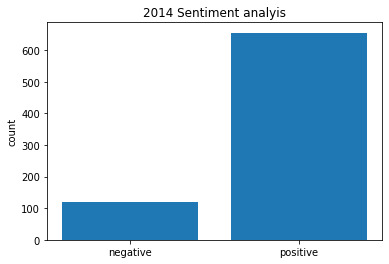

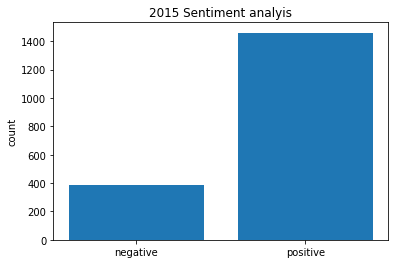

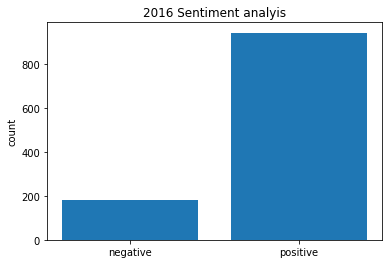

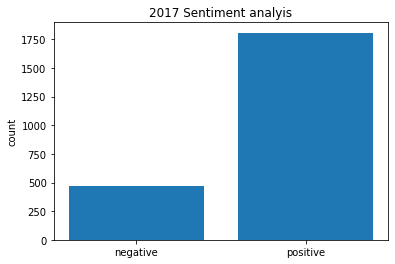

In [20]:
for key, val in total_sentiment_frequency.items():
  plt.title(f'{key} Sentiment analyis')
  plt.bar(['negative', 'positive'], [val['Negative'], val['Positive']])
  plt.ylabel('count')
  plt.show()